In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import promonet


/home/mrm5248/conda/envs/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt


In [7]:
dist = torch.load('/files10/max/promonet/promonet/assets/stats/vctk-train-pitch-256.pt')
dist = torch.cat((dist, torch.tensor([promonet.FMAX])))


In [10]:
cents_per_bin = 1200 * (torch.log2(dist[1:]) - torch.log2(dist[:-1]))


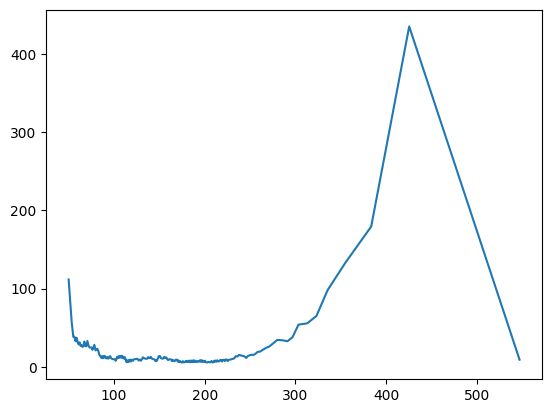

In [24]:
plt.plot(dist[:-1],  cents_per_bin)
